<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_horizontal.svg"
     width="60%"
     alt="Dask logo\" />

# Dask Delayed

Dask DataFrames, Dask Arrays and Dask-ML are parallel versions of PyData libraries you likely know and love. But sometimes we encounter problems that could benefit from parallel computing but that do no fit neatly into a DataFrame, Array or Machine-Learning workflow.

Dask delayed is an interface that can be used to parallelize existing Python code and custom algorithms. 

A first step to determine if we can use `dask.delayed` is to identify if there is some level of parallelism that we haven't exploit and hopefully `dask.delayed` will take care of it. 

The following two functions will perform simple computations, where we use the `sleep` to simulate work. 

In [1]:
from time import sleep

def inc(x):
    """Increments x by one"""
    sleep(1)
    return x + 1

def add(x, y):
    """Adds x and y"""
    sleep(1)
    return x + y

Let's do some operations and time these functions using the `%%time` magic at the beginning of the cell. 

In [2]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.12 ms, sys: 1.43 ms, total: 2.55 ms
Wall time: 3.01 s


The execution of the cell above took three seconds, this happens because we are calling  each function sequentially. The computations above can be represented by the following graph:

<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/inc-add.svg" 
     width="55%"
     alt="Dask graph\" />

From looking at the task graph, the opportunity for parallelization is more evident since the the two calls to the `inc` function are completely independent of one-another. Let's explore how `dask.delayed` can help us with this.


### `dask.delayed` 

We can use `dask.delayed` to transform the `inc` and `add` functions into "lazy" versions of themselves. 

In [3]:
from dask import delayed

In [4]:
%%time

# x = inc(1)
# y = inc(2)
# z = add(x, y)

a = delayed(inc)(1)
b = delayed(inc)(2)
c = delayed(add)(a, b)

CPU times: user 360 µs, sys: 80 µs, total: 440 µs
Wall time: 416 µs


When we call the `delayed` version of the functions by passing the arguments, the original function is isn't actually called yet, that's why the execution finishes very quickly. When we called the `delayed` version of the functions, a `delayed` object is made, which keeps track of the functions to call and what arguments to pass to it. 

If we inspect `c`, we will notice that it instead of having the value five, we have what is called a `delayed` object.

In [5]:
print(c)

Delayed('add-79e19861-2a04-4ea9-b658-6cb1e65fe8ef')


We can visualize this objects by doing:

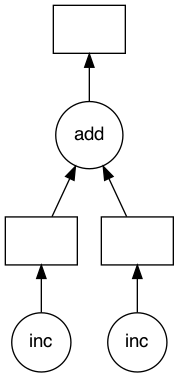

In [6]:
c.visualize()

Up to this point the object `c` holds all the information we need to compute the result. We can evaluate the result with `.compute()`.

In [7]:
%%time

c.compute()

CPU times: user 3.29 ms, sys: 2.6 ms, total: 5.89 ms
Wall time: 2.01 s


5

Notice that now the computation took 2s instead of 3s, this is because the two `inc` computations are run in parallel. 

## Parallelizing a `for`-loop

When we perform the same group of operation multiple times in the form of `for-loop`, there is a chance that we can perform this computations in parallel. For example, the following serial code, can be parallelized using `delayed`: 

In [9]:
data = list(range(8))

#### Sequential code

In [10]:
%%time
results = []
for i in data:
    y = inc(i)         # do something here
    results.append(y)
    
total = sum(results)  # do something here

CPU times: user 1.43 ms, sys: 1.68 ms, total: 3.11 ms
Wall time: 8.03 s


In [11]:
print(f'{total = }')

total = 36


### Exercise 1 

Notice that both the `inc` and `sum` operations can be done in parallel, use `delayed` to parallelize the sequential code above, compute the `total` and time it using `%%time` 

Uncomment and run the cell below to see the solution.

In [13]:
# %load ./solutions/delayed-ex-1.py
results = []
for i in data:
    y = delayed(inc)(i)    
    results.append(y)
    
total = delayed(sum)(results)

In the code above, the `sum` step is not run in parallel, but it depends on each of the `inc` steps, that's why it needs the `delayed` decorator too. The `inc`steps will be parallelized, then aggregated with the `sum` step.

Notice that we can apply delayed to built-in functions, as we did in the case of `sum` in the code above. 

In [14]:
total

Delayed('sum-fcc1e4de-f069-4456-b25a-e4f277b2e62c')

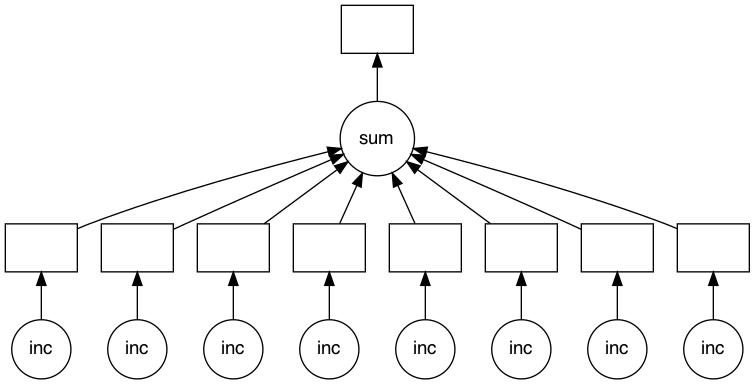

In [15]:
total.visualize()

In [16]:
%%time
total.compute()

CPU times: user 3.63 ms, sys: 2.67 ms, total: 6.3 ms
Wall time: 1.01 s


36

###  The `@delayed` syntax 

The `delayed` decorator can be also used by "decorating" with `@delayed` the function you want to parallelize.

In [17]:
@delayed                    
def double(x):
    """Decrease x by one"""
    sleep(1)
    return 2*x 

Then when we call this new `double` function we obtain a delayed object:

In [18]:
d = double(4)
print(d)

Delayed('double-f8f11f34-e142-4c42-936d-c99ad8e4a203')


In [19]:
%%time
d.compute()

CPU times: user 1.66 ms, sys: 1.31 ms, total: 2.97 ms
Wall time: 1.01 s


8

### Exercise 2

Using the `delayed` decorator create the parallel versions of `inc` and `add`

```python
def inc(x):
    """Increments x by one"""
    sleep(1)
    return x + 1

def add(x, y):
    """Adds x and y"""
    sleep(1)
    return x + y
```

In [21]:
# %load ./solutions/delayed-ex-2.py
@delayed
def inc(x):
    """Increments x by one"""
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    """Adds x and y"""
    sleep(1)
    return x + y

``Delayed`` objects support several standard Python operations, each of which creates another ``Delayed`` object representing the result:

- Arithmetic operators, e.g. `*`, `-`, `+`
- Item access and slicing, e.g. `x[0]`, `x[1:3]`
- Attribute access, e.g. `x.size`
- Method calls, e.g. `x.index(0)`

For example you can do:

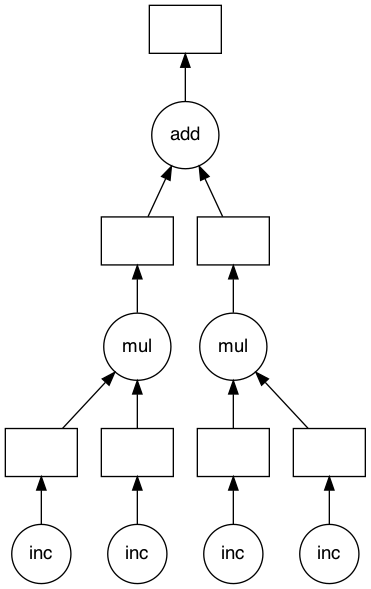

In [22]:
result = (inc(5) * inc(7)) + (inc(3) * inc(2))
result.visualize()

In [23]:
%%time
result.compute()

CPU times: user 3 ms, sys: 2.19 ms, total: 5.19 ms
Wall time: 1.01 s


60

## Another for-loop example 

Let's say we want to perform some operations like `inc`, `double` and `add` on a list of data, and finally aggregate all the results. We can use our `delayed` decorated functions to perform this computations faster. 
The serial version of the code below would take approximately 24 seconds, let's see how long does the parallel version takes:

In [27]:
data = list(range(8))

output = []
for x in data:
    a = inc(x)     #parallel version
    b = double(x)  #parallel version
    c = add(a, b)  #parallel version
    output.append(c)

total = delayed(sum)(output)
total

Delayed('sum-250a1dd3-741e-4721-969b-33e784baea38')

Noticed that `inc`, `double` and `add` in the code above are already the parallel versions, since we decorated with `@delayed`

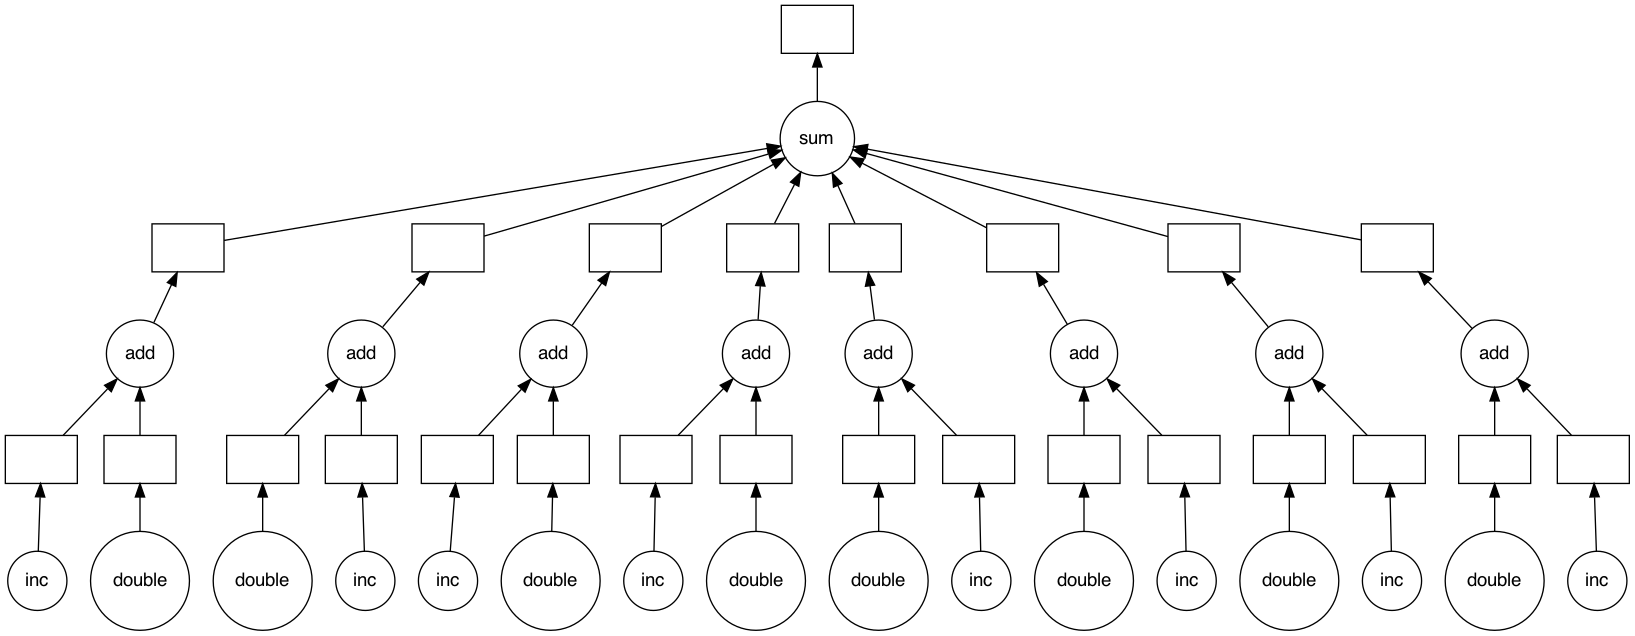

In [28]:
total.visualize()

### Exercise: How long will this task graph take to compute on a machine with 8 cores?

In [29]:
%%time
total.compute()

CPU times: user 7.52 ms, sys: 3.61 ms, total: 11.1 ms
Wall time: 3.02 s


92

## Extra resources

For more examples on `dask.delayed` check:
- Main Dask tutorial: [Delayed lesson](https://github.com/dask/dask-tutorial/blob/main/01_dask.delayed.ipynb)
- More examples on Delayed: [PyData global - Dask tutorial - Delayed](https://github.com/coiled/pydata-global-dask/blob/master/1-delayed.ipynb)
- Short screencast on Dask delayed: [How to parallelize Python code with Dask Delayed (3min)](https://www.youtube.com/watch?v=-EUlNJI2QYs)
- [Dask Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
- [Delayed Best Practices](https://docs.dask.org/en/latest/delayed-best-practices.html)
